### 0. Library Import & Data Loading

In [2]:
import pandas as pd
import numpy as np
import gc # Garbage Collector interface
%matplotlib inline

In [2]:
# data loading
aisles = pd.read_csv('./input/aisles.csv')
dep = pd.read_csv('./input/departments.csv')
ord_prd_pr = pd.read_csv('./input/order_products__prior.csv')
ord_prd_tr = pd.read_csv('./input/order_products__train.csv')
orders = pd.read_csv('./input/orders.csv')
products = pd.read_csv('./input/products.csv')

In [3]:
# Changing some columns types to int for less memory usage
aisles['aisle'] = aisles['aisle'].astype('category')
dep['department'] = dep['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

products.drop(['product_name'], axis=1, inplace=True)
products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

ord_prd_tr.reordered = ord_prd_tr.reordered.astype(np.int8)
ord_prd_tr.add_to_cart_order = ord_prd_tr.add_to_cart_order.astype(np.int16)

ord_prd_pr.order_id = ord_prd_pr.order_id.astype(np.int32)
ord_prd_pr.add_to_cart_order = ord_prd_pr.add_to_cart_order.astype(np.int16)
ord_prd_pr.reordered = ord_prd_pr.reordered.astype(np.int8)
ord_prd_pr.product_id = ord_prd_pr.product_id.astype(np.int32)

In [4]:
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('products {}: {}'.format(products.shape, ', '.join(products.columns)))
print('ord_prd_tr {}: {}'.format(ord_prd_tr.shape, ', '.join(ord_prd_tr.columns)))
print('ord_prd_pr {}: {}'.format(ord_prd_pr.shape, ', '.join(ord_prd_pr.columns)))

orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products (49688, 3): product_id, aisle_id, department_id
ord_prd_tr (1384617, 4): order_id, product_id, add_to_cart_order, reordered
ord_prd_pr (32434489, 4): order_id, product_id, add_to_cart_order, reordered


In [5]:
ord_prd_pr.tail(3)

,order_id,product_id,add_to_cart_order,reordered
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [6]:
ord_prd_tr.tail(3)

,order_id,product_id,add_to_cart_order,reordered
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [7]:
orders.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [8]:
products.tail(3)

,product_id,aisle_id,department_id
49685,49686,112,3
49686,49687,41,8
49687,49688,73,11


In [9]:
dep.tail(3)

,department_id,department
18,19,snacks
19,20,deli
20,21,missing


In [10]:
aisles.tail(3)

,aisle_id,aisle
131,132,beauty
132,133,muscles joints pain relief
133,134,specialty wines champagnes


### 1. EDA

### 2. Feature Engineering

#### (1) Product data reshaping (products + department + aisles)

In [11]:
df_products = pd.merge(left = products, right = dep, on = 'department_id', how = 'left')
goods = pd.merge(left = df_products, right = aisles, on = 'aisle_id', how = 'left')
goods.tail(3)

,product_id,aisle_id,department_id,department,aisle
49685,49686,112,3,bakery,bread
49686,49687,41,8,pets,cat food care
49687,49688,73,11,personal care,facial care


In [12]:
goods.drop(['department_id'], axis = 1, inplace = True)
goods.drop(['aisle_id'], axis = 1, inplace = True)
goods.tail(3)

,product_id,department,aisle
49685,49686,bakery,bread
49686,49687,pets,cat food care
49687,49688,personal care,facial care


#### (2) Product data 

In [13]:
ord_prd_tr = ord_prd_tr.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')
ord_prd_tr.tail(3)

,order_id,product_id,add_to_cart_order,reordered,user_id
1384614,3421070,35951,1,1,139822
1384615,3421070,16953,2,1,139822
1384616,3421070,4724,3,1,139822


In [14]:
orders_products_pr = orders.merge(ord_prd_pr, how = 'inner', on = 'order_id')

In [15]:
orders_products_pr.tail(3) 

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0
32434488,2977660,206209,prior,13,1,12,7.0,22920,9,0


In [16]:
# sorting orders and products to get the rank or the reorder times for the product
prdss = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [17]:
prdss.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434483,2977660,206209,prior,13,1,12,7.0,39216,4,0


In [18]:
prdot = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [19]:
prdot.shape

(32434489, 10)

In [20]:
prdot.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
32434488,2977660,206209,prior,13,1,12,7.0,22920,9,0
32434480,2977660,206209,prior,13,1,12,7.0,24852,1,1
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434483,2977660,206209,prior,13,1,12,7.0,39216,4,0


In [21]:
# product time 생성: 유저별 & 제품별 구매 횟수
prdss = prdss.assign(product_time = prdss.groupby(['user_id', 'product_id']).cumcount()+1)

In [22]:
prdss.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_time
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0,1
32434483,2977660,206209,prior,13,1,12,7.0,39216,4,0,1


In [23]:
# prod_average_cart_position: 제품별 평균 카트에 담긴 순서
sub = prdss.groupby(['product_id'])['add_to_cart_order'].mean().to_frame('prod_average_cart_position')

In [26]:
sub.tail(3)

,prod_average_cart_position
product_id,
49686,7.500000
49687,7.538462
49688,10.000000


In [25]:
# getting products ordered first and second times 나중에 확률 계산을 하기 위해 
# sub1: 제품별 첫번째로 구매한 횟수, 
# sub2: 제품별 두번째로 구매한 횟수
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

In [27]:
sub1.tail(3)

,prod_first_orders
product_id,
49686,36
49687,7
49688,74


In [28]:
sub2.tail(3)

,prod_second_orders
product_id,
49686,16
49687,4
49688,11


In [29]:
# sub1에 prod_orders 추가: 제품별 총구매횟수
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()

In [30]:
sub1.tail(3)

,prod_first_orders,prod_orders
product_id,,
49686,36,120
49687,7,13
49688,74,89


In [31]:
# sub1에 prod_reorders 추가: 제품별 재구매횟수
# prod_orders(제품별 총구매횟수) = prod_first_orders (제품별 첫번째 주문횟수) + prod_reorders (제품별 재구매횟수)
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()

In [32]:
sub1.tail(3)

,prod_first_orders,prod_orders,prod_reorders
product_id,,,
49686,36,120,84.0
49687,7,13,6.0
49688,74,89,15.0


In [33]:
# sub1과 sub2 합침
sub2 = sub2.reset_index().merge(sub1.reset_index())

In [34]:
sub2.tail(3)

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders
45302,49686,16,36,120,84.0
45303,49687,4,7,13,6.0
45304,49688,11,74,89,15.0


In [35]:
print('sub2 {}: {}'.format(sub2.shape, ', '.join(sub2.columns)))

sub2 (45305, 5): product_id, prod_second_orders, prod_first_orders, prod_orders, prod_reorders


In [36]:
# calculating reorder probability and ratio for the product
# 'prod_reorder_probability' : 제품별 재구매 될 확률 (= 제품별 2번째 구매횟수 / 제품별 첫구매횟수)
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']

In [37]:
sub2.tail(3)

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders,prod_reorder_probability
45302,49686,16,36,120,84.0,0.444444
45303,49687,4,7,13,6.0,0.571429
45304,49688,11,74,89,15.0,0.148649


In [38]:
# 'prod_reorder_times' 제품 평균 재주문 횟수 : 1 + (제품별 재구매 횟수 /제품별 첫구매횟수) 
sub2['prod_reorder_times'] = 1 + sub2['prod_reorders']/sub2['prod_first_orders']

In [39]:
sub2.tail(3)

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders,prod_reorder_probability,prod_reorder_times
45302,49686,16,36,120,84.0,0.444444,3.333333
45303,49687,4,7,13,6.0,0.571429,1.857143
45304,49688,11,74,89,15.0,0.148649,1.202703


In [40]:
# 'prod_reorder_ratio' 재구매 비율 = 재구매 횟수 / 총주문 횟수
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']

In [41]:
sub2.tail(3)

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio
45302,49686,16,36,120,84.0,0.444444,3.333333,0.700000
45303,49687,4,7,13,6.0,0.571429,1.857143,0.461538
45304,49688,11,74,89,15.0,0.148649,1.202703,0.168539


In [42]:
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio']]

In [43]:
prd.tail(3)

,product_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio
45302,49686,120,0.444444,3.333333,0.700000
45303,49687,13,0.571429,1.857143,0.461538
45304,49688,89,0.148649,1.202703,0.168539


In [44]:
# Memory cleaning 
del sub1, sub2
gc.collect()

241

#### (3) User Data

In [45]:
# user_orders 생성 - 유저별로 order 한 횟수
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('user_orders')

In [46]:
users.tail(3)

,user_orders
user_id,
206207,16
206208,49
206209,13


In [47]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (206209, 1): user_orders


In [48]:
# user_period 생성 - 이전 오더 이후 주문일 합계
users['user_period'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()

In [49]:
users.tail(3)

,user_orders,user_period
user_id,,
206207,16,215.0
206208,49,357.0
206209,13,210.0


In [50]:
# user_mean_days_since_prior 생성 - 평균 주문소요일
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()

In [51]:
users.tail(3)

,user_orders,user_period,user_mean_days_since_prior
user_id,,,
206207,16,215.0,14.333333
206208,49,357.0,7.437500
206209,13,210.0,17.500000


In [52]:
# merging features about users and orders into one dataset
# user_total_products 생성 - user id 별 주문한 product의 수
us = orders_products_pr.groupby('user_id').size().to_frame('user_total_products')

In [53]:
us.tail(3)

,user_total_products
user_id,
206207,223
206208,677
206209,129


In [54]:
# eq_1 - 그 중 재주문한 product의 수
us['eq_1'] = orders_products_pr[orders_products_pr['reordered'] == 1].groupby('user_id')['product_id'].size()

In [55]:
us.tail(3)

,user_total_products,eq_1
user_id,,
206207,223,131.0
206208,677,479.0
206209,129,61.0


In [56]:
# qt_1 - 유저별로 첫번째 주문을 제외한 주문의 product의 수
us['gt_1'] = orders_products_pr[orders_products_pr['order_number'] > 1].groupby('user_id')['product_id'].size()

In [57]:
us.tail(3)

,user_total_products,eq_1,gt_1
user_id,,,
206207,223,131.0,199
206208,677,479.0,665
206209,129,61.0,116


In [58]:
# user_reorder_ratio: user 별 재구매 비율 (=재주문한 product의 수 / 첫번째 주문을 제외한 주문의 product의 수)
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']

In [59]:
us.tail(3)

,user_total_products,eq_1,gt_1,user_reorder_ratio
user_id,,,,
206207,223,131.0,199,0.658291
206208,677,479.0,665,0.720301
206209,129,61.0,116,0.525862


In [60]:
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)

In [61]:
# user_distinct_products: user 별 주문한 product 종류의 수
us['user_distinct_products'] = orders_products_pr.groupby(['user_id'])['product_id'].nunique()

In [62]:
us.tail(3)

,user_total_products,user_reorder_ratio,user_distinct_products
user_id,,,
206207,223,0.658291,92
206208,677,0.720301,198
206209,129,0.525862,68


In [63]:
# users와 us 결합
users = users.reset_index().merge(us.reset_index())

In [64]:
users.tail(3)

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products
206206,206207,16,215.0,14.333333,223,0.658291,92
206207,206208,49,357.0,7.437500,677,0.720301,198
206208,206209,13,210.0,17.500000,129,0.525862,68


In [65]:
# user_average_basket : 유저별 주문당 평균 제품 개수
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

In [66]:
users.tail(3)

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket
206206,206207,16,215.0,14.333333,223,0.658291,92,13.937500
206207,206208,49,357.0,7.437500,677,0.720301,198,13.816327
206208,206209,13,210.0,17.500000,129,0.525862,68,9.923077


In [67]:
# test, train order 만..
us2 = orders[orders['eval_set'] != 'prior'] 

In [68]:
us2.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421018,2821651,206207,test,17,2,13,14.0
3421068,803273,206208,test,50,5,11,4.0
3421082,272231,206209,train,14,6,14,30.0


In [69]:
us2 = us2[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

In [70]:
us2.tail(3)

,user_id,order_id,eval_set,days_since_prior_order
3421018,206207,2821651,test,14.0
3421068,206208,803273,test,4.0
3421082,206209,272231,train,30.0


In [71]:
users = users.merge(us2)

In [72]:
users.tail(3)

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
206206,206207,16,215.0,14.333333,223,0.658291,92,13.937500,2821651,test,14.0
206207,206208,49,357.0,7.437500,677,0.720301,198,13.816327,803273,test,4.0
206208,206209,13,210.0,17.500000,129,0.525862,68,9.923077,272231,train,30.0


In [73]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (206209, 11): user_id, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order


#### (4) Order data (related with User & Product data) 

In [74]:
# up_orders: user, product 별 주문수
data = orders_products_pr.groupby(['user_id', 'product_id']).size().to_frame('up_orders')

In [75]:
data.tail(3)

up_orders
user_id product_id           
206209  48370               1
        48697               1
        48742               2

In [76]:
# up_first_order: 해당 product를 최초 주문한 주문순서
data['up_first_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].min()

In [77]:
data.tail(3)

up_orders  up_first_order
user_id product_id                           
206209  48370               1              11
        48697               1               7
        48742               2               7

In [78]:
# up_last_order: 해당 product를 최초 주문한 주문순서
data['up_last_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].max()

In [79]:
data.tail(3)

up_orders  up_first_order  up_last_order
user_id product_id                                          
206209  48370               1              11             11
        48697               1               7              7
        48742               2               7             12

In [80]:
# avg_cart_position : 제품별로 cart에 담은 순서의 평균 
data['up_average_cart_position'] = orders_products_pr.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

In [81]:
data.tail(3)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
13307950,206209,48370,1,11,11,8.0
13307951,206209,48697,1,7,7,6.0
13307952,206209,48742,2,7,12,9.0


In [82]:
# user, product data와 결합
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

In [83]:
data.tail()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
13278018,120516,8566,5,1,5,1.0,140,0.500000,2.592593,0.614286,7,100.0,16.666666,7,0.833333,2,1.0,3264957,train,14.0
13278019,120516,40072,2,6,7,1.0,25,0.466667,1.666667,0.400000,7,100.0,16.666666,7,0.833333,2,1.0,3264957,train,14.0
13278020,166751,49001,3,1,3,1.0,45,0.193548,1.451613,0.311111,3,20.0,10.000000,3,1.000000,1,1.0,2080697,train,14.0
13278021,106143,19675,26,1,26,1.0,39,0.833333,6.500000,0.846154,26,191.0,7.640000,26,1.000000,1,1.0,1714200,test,9.0
13278022,66343,47210,4,1,4,1.0,11,0.285714,1.571429,0.363636,4,79.0,26.333334,4,1.000000,1,1.0,2913671,test,30.0


In [84]:
print('data {}: {}'.format(data.shape, ', '.join(data.columns)))

data (13278023, 20): user_id, product_id, up_orders, up_first_order, up_last_order, up_average_cart_position, prod_orders, prod_reorder_probability, prod_reorder_times, prod_reorder_ratio, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order


In [85]:
# up_order_rate 유저별/제품별 주문비율 : 유저별/제품별 주문횟수 / 유저별 총 주문수
data['up_order_rate'] = data['up_orders'] / data['user_orders']

In [86]:
data['up_order_rate'].tail(3)

13278020    1.0
13278021    1.0
13278022    1.0
Name: up_order_rate, dtype: float64

In [87]:
# up_orders_since_last_order 제품별 최종 주문 이후 유저 주문수: 유저별 총 주문수 - 유저별/제품별 최종 주문수
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

In [88]:
data['up_orders_since_last_order'].tail(5)

13278018    2
13278019    0
13278020    0
13278021    0
13278022    0
Name: up_orders_since_last_order, dtype: int16

In [89]:
# up_order_rate_since_first_order 
# 첫번째 주문 이후 유저별/제품별 주문율 : 유저별/제품별 주문수 / (유저별 총주문수 - 유저별/제품별 최초주문순서 + 1)
data['up_order_rate_since_first_order'] = data['up_orders'] / (data['user_orders'] - data['up_first_order'] + 1)

In [93]:
data.tail(3)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
13278020,166751,49001,3,1,3,1.0,45,0.193548,1.451613,0.311111,...,1.0,1,1.0,2080697,train,14.0,1.0,0,1.0,1.0
13278021,106143,19675,26,1,26,1.0,39,0.833333,6.500000,0.846154,...,1.0,1,1.0,1714200,test,9.0,1.0,0,1.0,NaN
13278022,66343,47210,4,1,4,1.0,11,0.285714,1.571429,0.363636,...,1.0,1,1.0,2913671,test,30.0,1.0,0,1.0,NaN


In [91]:
# reordered 추가
data = data.merge(ord_prd_tr[['user_id', 'product_id', 'reordered']], how = 'left', on = ['user_id', 'product_id'])

In [94]:
data.tail(3)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
13278020,166751,49001,3,1,3,1.0,45,0.193548,1.451613,0.311111,...,1.0,1,1.0,2080697,train,14.0,1.0,0,1.0,1.0
13278021,106143,19675,26,1,26,1.0,39,0.833333,6.500000,0.846154,...,1.0,1,1.0,1714200,test,9.0,1.0,0,1.0,NaN
13278022,66343,47210,4,1,4,1.0,11,0.285714,1.571429,0.363636,...,1.0,1,1.0,2913671,test,30.0,1.0,0,1.0,NaN


#### (5) Association Analysis

In [191]:
data.to_csv('my_data.csv', header = True, index = False)

In [2]:
data = pd.read_csv('my_data.csv')

In [3]:
from mlxtend.frequent_patterns import apriori #import apriori
from mlxtend.frequent_patterns import association_rules

In [52]:
data2 = data.sort_values('prod_orders', ascending=False)

In [38]:
data_ = data.sort_values('up_orders', ascending=False)

In [53]:
data3 = data2[:3000000] # 한계는 3000000 까지인듯..`

In [39]:
data4 = data_[:1000000]

In [12]:
data4.head(10)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
12289659,17997,4210,99,1,99,2.292929,35633,0.581177,4.519660,0.778744,...,0.986111,9,4.393939,77060,test,4.0,1.000000,0,1.000000,NaN
1653388,41356,6583,99,1,99,6.484848,769,0.582734,5.532374,0.819246,...,0.953033,93,15.696970,325094,train,2.0,1.000000,0,1.000000,1.0
1653391,41356,38652,99,1,99,6.494949,693,0.572289,4.174699,0.760462,...,0.953033,93,15.696970,325094,train,2.0,1.000000,0,1.000000,1.0
1653387,41356,14366,99,1,99,7.464646,1753,0.605479,4.802740,0.791786,...,0.953033,93,15.696970,325094,train,2.0,1.000000,0,1.000000,1.0
4214231,141736,25133,99,1,99,3.090909,6196,0.580745,3.848447,0.740155,...,0.967347,50,12.474747,2659599,test,2.0,1.000000,0,1.000000,NaN
6756974,103593,28204,98,1,99,8.602041,89632,0.551954,3.471283,0.711922,...,0.973665,49,14.313131,1369980,train,1.0,0.989899,0,0.989899,1.0
12837860,120897,12013,98,1,99,1.408163,3977,0.429625,2.444376,0.590898,...,0.881416,71,5.747475,1866722,test,2.0,0.989899,0,0.989899,NaN
1653400,41356,29671,98,1,99,7.530612,623,0.509317,3.869565,0.741573,...,0.953033,93,15.696970,325094,train,2.0,0.989899,0,0.989899,1.0
211627,99707,24852,97,1,99,4.278351,472565,0.745930,6.389813,0.843501,...,0.926829,91,11.282828,1247049,train,3.0,0.979798,0,0.979798,1.0
208085,98085,196,97,1,99,1.917526,35791,0.582500,4.473875,0.776480,...,0.931338,50,5.848485,220268,test,2.0,0.979798,0,0.979798,NaN


In [54]:
basket = (data3
          .groupby(['user_id','product_id'])['up_orders']
          .sum()
          .unstack()
          .reset_index().fillna(0)  
          .set_index('user_id')
         )

In [79]:
basket.tail()

product_id,196,260,432,890,1463,1940,2078,2295,3957,4210,...,46979,47144,47209,47626,47672,47734,47766,48679,49235,49683
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
206206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
206207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
206208,0.0,0.0,0.0,2.0,8.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0
206209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [57]:
basket_sets.head()

product_id,196,260,432,890,1463,1940,2078,2295,3957,4210,...,46979,47144,47209,47626,47672,47734,47766,48679,49235,49683
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
frequent_itemsets = apriori(basket_sets, min_support=0.1)##

In [59]:
frequent_itemsets.head()

,support,itemsets
0,0.151340,[10]
1,0.139262,[12]
2,0.137734,[20]
3,0.113943,[28]
4,0.129873,[30]


In [70]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01) 

In [71]:
rules

,antecedants,consequents,support,confidence,lift
0,(40),(67),0.321617,0.469207,1.575413
1,(67),(40),0.297831,0.506679,1.575413
2,(40),(72),0.321617,0.414215,1.486824
3,(72),(40),0.278591,0.478187,1.486824
4,(40),(86),0.321617,0.312180,0.833912
5,(86),(40),0.374357,0.268200,0.833912
6,(40),(188),0.321617,0.379511,1.725412
7,(188),(40),0.219954,0.554921,1.725412
8,(50),(86),0.218415,0.541426,1.446285
9,(86),(50),0.374357,0.315891,1.446285


In [77]:
rules[ (rules['lift'] >= 1.5) &
       (rules['confidence'] >= 0.01) ]

,antecedants,consequents,support,confidence,lift
0,(40),(67),0.321617,0.469207,1.575413
1,(67),(40),0.297831,0.506679,1.575413
6,(40),(188),0.321617,0.379511,1.725412
7,(188),(40),0.219954,0.554921,1.725412
10,(72),(67),0.278591,0.498029,1.672185
11,(67),(72),0.297831,0.465855,1.672185
14,(67),(92),0.297831,0.351151,1.546436
15,(92),(67),0.227071,0.460576,1.546436
16,(146),(67),0.187988,0.576095,1.934300
17,(67),(146),0.297831,0.363626,1.934300


#### (6) 최종 train, test dataset 

In [ ]:
# train set 생성
train = data[data['eval_set'] == 'train']

In [ ]:
train['reordered'].fillna(0, inplace=True) # NaN 값 0으로 치환
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1, inplace = True) # training feature 외 feature 제외

In [ ]:
train.shape

In [ ]:
train.columns

In [ ]:
# filter by eval_set = test, replace Nan with zeros (not reordered) 
test = data[data['eval_set'] == 'test']
test['reordered'].fillna(0, inplace=True)
test.drop(['eval_set', 'user_id'], axis = 1, inplace = True)

In [ ]:
test.shape

In [ ]:
# Saving train and test sets to files for easier loading to model, without having to re-prepare the data.
train.to_csv('my_train3.csv', header = True, index = False)
test.to_csv('my_test3.csv', header = True, index = False)

### 3. Model Selection & Preparation

In [3]:
# loading files
train = pd.read_csv('my_train4.csv')
test = pd.read_csv('my_test4.csv')

In [4]:
# Splitting the training set to train and validation set. Validation set 
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.33, random_state=7)

#### (1) LightGBM model

In [5]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [6]:
print('formatting to LightGBM format ...')
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',              # Gradient boosting tree algorithm
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000,              
    'max_bin' : 100,                      # Controls overfit
    'num_leaves': 512,                    # higher number of leaves
    'feature_fraction': 0.9,              # Controls overfit
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'min_data_in_leaf' : 200,             # Controls overfit
    'learning_rate' : 0.1,
    #'device' : 'gpu',                     # Disable this if not using GPU
    #'gpu_use_dp' : True,                  # To make GPU use double precision
}

formatting to LightGBM format ...


In [7]:
print('training LightGBM model ...')
lgb_model = lgb.train(params,
                lgb_train,
                num_boost_round = 200,     
                valid_sets = lgb_eval,     # Validation set used to prevent overfitting
                early_stopping_rounds=10)  # will stop the boost rounds if evaluation metricices didn't improve

training LightGBM model ...
[1]	valid_0's auc: 0.826059	valid_0's binary_logloss: 0.625196
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's auc: 0.826801	valid_0's binary_logloss: 0.569915
[3]	valid_0's auc: 0.828213	valid_0's binary_logloss: 0.523781
[4]	valid_0's auc: 0.828208	valid_0's binary_logloss: 0.485306
[5]	valid_0's auc: 0.828977	valid_0's binary_logloss: 0.452511
[6]	valid_0's auc: 0.829361	valid_0's binary_logloss: 0.424586
[7]	valid_0's auc: 0.82959	valid_0's binary_logloss: 0.400749
[8]	valid_0's auc: 0.829828	valid_0's binary_logloss: 0.380193
[9]	valid_0's auc: 0.83002	valid_0's binary_logloss: 0.362615
[10]	valid_0's auc: 0.830254	valid_0's binary_logloss: 0.347249
[11]	valid_0's auc: 0.830493	valid_0's binary_logloss: 0.333938
[12]	valid_0's auc: 0.830618	valid_0's binary_logloss: 0.322381
[13]	valid_0's auc: 0.830648	valid_0's binary_logloss: 0.31245
[14]	valid_0's auc: 0.830909	valid_0's binary_logloss: 0.303676
[15]	valid_0's auc: 0.831037	valid

[128]	valid_0's auc: 0.836565	valid_0's binary_logloss: 0.243768
[129]	valid_0's auc: 0.836572	valid_0's binary_logloss: 0.243763
[130]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.243753
[131]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.243745
[132]	valid_0's auc: 0.836613	valid_0's binary_logloss: 0.243744
[133]	valid_0's auc: 0.836613	valid_0's binary_logloss: 0.243745
[134]	valid_0's auc: 0.836607	valid_0's binary_logloss: 0.243747
[135]	valid_0's auc: 0.836608	valid_0's binary_logloss: 0.243746
[136]	valid_0's auc: 0.836617	valid_0's binary_logloss: 0.243742
[137]	valid_0's auc: 0.836613	valid_0's binary_logloss: 0.243745
[138]	valid_0's auc: 0.836614	valid_0's binary_logloss: 0.243745
[139]	valid_0's auc: 0.836613	valid_0's binary_logloss: 0.243747
[140]	valid_0's auc: 0.836611	valid_0's binary_logloss: 0.243749
[141]	valid_0's auc: 0.836635	valid_0's binary_logloss: 0.243736
[142]	valid_0's auc: 0.836635	valid_0's binary_logloss: 0.243738
[143]	valid_0's auc: 0.836

In [8]:
print('applying model to test data ...')
test['reordered'] = lgb_model.predict(test[test.columns.difference(['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)

applying model to test data ...


In [9]:
test['reordered']

0          0.200484
1          0.073121
2          0.110968
3          0.075341
4          0.088786
5          0.065722
6          0.071958
7          0.127876
8          0.078222
9          0.076618
10         0.111082
11         0.294731
12         0.144710
13         0.302592
14         0.176853
15         0.212967
16         0.259604
17         0.178293
18         0.135276
19         0.108806
20         0.191442
21         0.175999
22         0.196087
23         0.086265
24         0.098965
25         0.128647
26         0.089556
27         0.135629
28         0.217271
29         0.110645
             ...   
4822258    0.151414
4822259    0.104353
4822260    0.086443
4822261    0.141394
4822262    0.128224
4822263    0.221899
4822264    0.093459
4822265    0.084823
4822266    0.012405
4822267    0.133685
4822268    0.061852
4822269    0.112835
4822270    0.128119
4822271    0.094726
4822272    0.060047
4822273    0.230553
4822274    0.113147
4822275    0.110518
4822276    0.096581


In [10]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered > 0.21:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('lightgbm_submit.csv', index=False)

formatting and writing to submission file ...


#### (2) XGBoost

In [174]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import graphviz

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [175]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_eval, y_eval) 
# parameter 참조 link : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_params = {
    "objective"         : "binary:logistic" # loss function. binary:logistic (logistic regression for binary classification => predicted class) # multi:softmax (multicalss classification using the softmax objective -> predicted class , ) # multi:softprob: softmax와 같으나 class 대신 probability를 return
    #,"num_class"        : 2                # multi:softmax 쓸 경우, num_class (number of unique classes) 세팅해줘야함
    ,"eval_metric"      : "auc"              # validation에 사용될 metric (종류: rmse, mae, logloss, error, merror, mlogloss, auc)
    ,"eta"              : 0.1                # learning rate in GBM과 유사한 개념 (통상 0.01 ~ 0.2 사이 값)
    ,"max_depth"        : 6                  # maximum depth of a tree (overfitting 방지 위해 사용. depth 클수록 구체적 관계 학습. 통상 3 - 10) 
    ,"min_child_weight" : 10                 # minimum sum of weights of all observations (default=1, overfitting 방지를 위해 사용, 너무 높으면 underfitting 우려)
    ,"gamma"            : 0.70                # 분할에 필요한 최소 손실 함수, 이 이상으로 감소할 때만 분할됨 (default = 0)
    ,"subsample"        : 0.76                # 각 트리에 대해 임의의 샘플이되는 관측 값의 비율. 낮은 값이 보수적&overfitting을 막음. 너무 낮으면 underfitting 우려 (통상 0.5 - 1)
    ,"colsample_bytree" : 0.95                # 각 트리에 대해 임의의 샘플이 되는 columns의 비율. (default 1, 통상 0.5 - 1)
    ,"alpha"            : 2e-05               # L1 regularization term on weights (Lasso Regression) (default=0)
    ,"lambda"           :1                   # L2 regularization term on weights.(Ridge Regression) (default=1)
}

watchlist  = [(xgb_eval,'eval'), (xgb_train,'train')]

In [176]:
print('training XGBoost model ...')
xgb_model = xgb.train(params = xgb_params,
                dtrain = xgb_train,
                num_boost_round = 200,
                evals = (watchlist),
                verbose_eval=10)  # will stop the boost rounds if evaluation metricices didn't improve

training XGBoost model ...
[0]	eval-auc:0.817311	train-auc:0.818241
[10]	eval-auc:0.826167	train-auc:0.826864
[20]	eval-auc:0.82814	train-auc:0.828857
[30]	eval-auc:0.830012	train-auc:0.830813
[40]	eval-auc:0.831263	train-auc:0.832118
[50]	eval-auc:0.8321	train-auc:0.833008
[60]	eval-auc:0.832734	train-auc:0.833717
[70]	eval-auc:0.833179	train-auc:0.834254
[80]	eval-auc:0.833453	train-auc:0.834619
[90]	eval-auc:0.83364	train-auc:0.834906
[100]	eval-auc:0.833827	train-auc:0.835172
[110]	eval-auc:0.833977	train-auc:0.83543
[120]	eval-auc:0.834114	train-auc:0.835656
[130]	eval-auc:0.834224	train-auc:0.83586
[140]	eval-auc:0.834322	train-auc:0.836054
[150]	eval-auc:0.834421	train-auc:0.836242
[160]	eval-auc:0.834537	train-auc:0.836437
[170]	eval-auc:0.834621	train-auc:0.836604
[180]	eval-auc:0.834727	train-auc:0.836811
[190]	eval-auc:0.834795	train-auc:0.836969


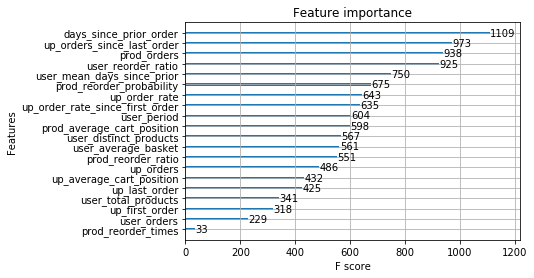

In [178]:
xgb.plot_importance(xgb_model)

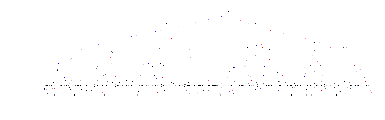

In [179]:
xgb.plot_tree(xgb_model, num_trees=1)

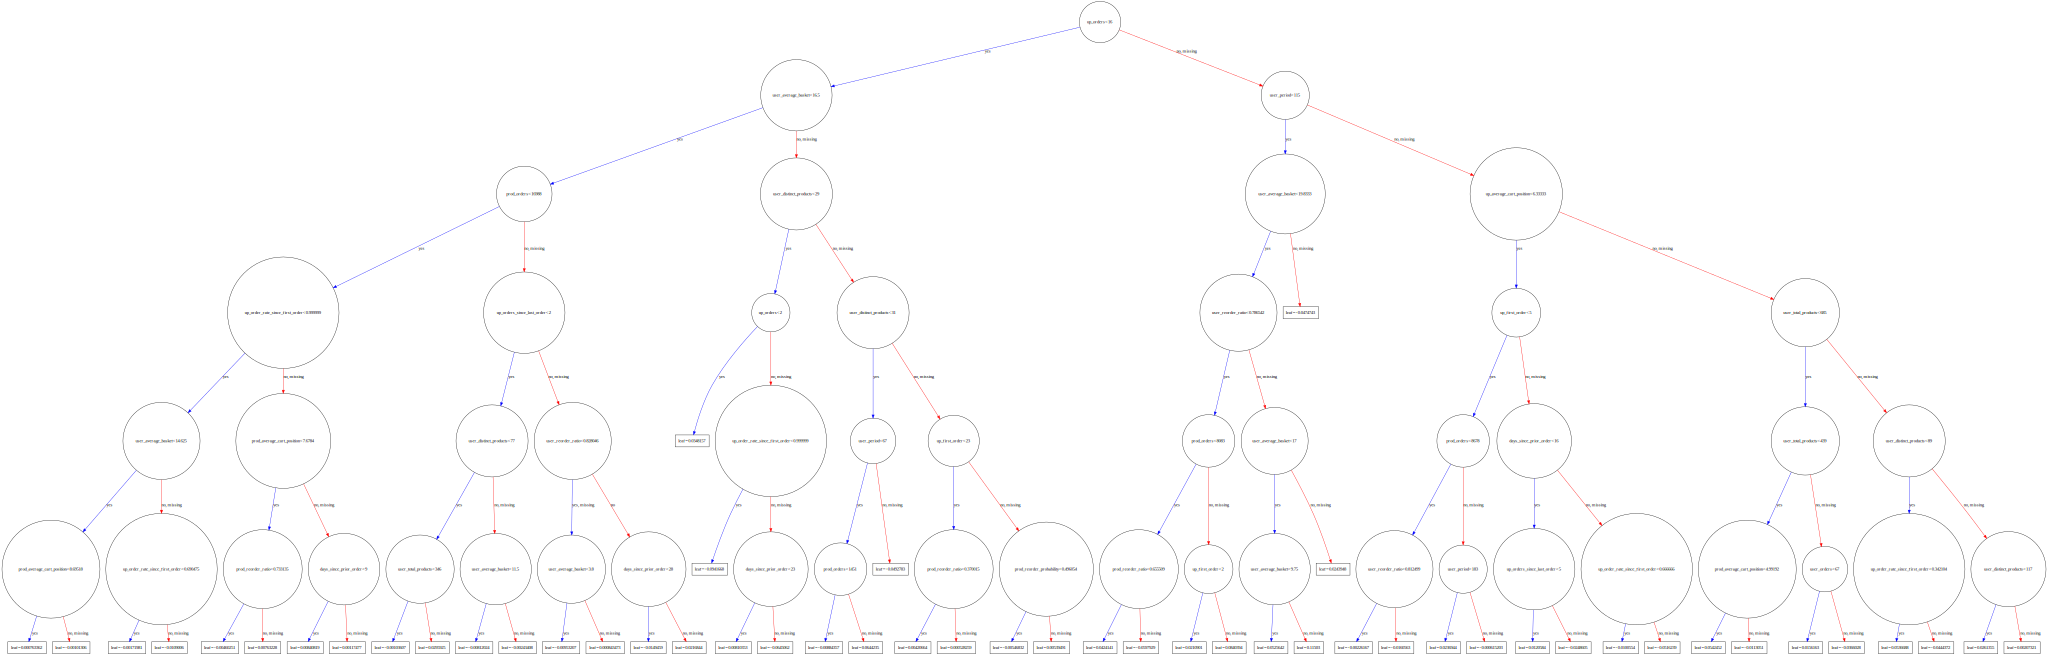

In [180]:
xgb.to_graphviz(xgb_model, num_trees=199)

In [181]:
X_test = test[test.columns.difference(['order_id', 'product_id'])]

In [182]:
X_test = X_test.drop(['reordered'], axis=1)

In [183]:
d_test = xgb.DMatrix(X_test)

In [184]:
test['reordered'] = xgb_model.predict(d_test)

In [185]:
test['reordered'].tail()

4822283    0.727474
4822284    0.822099
4822285    0.706639
4822286    0.920556
4822287    0.738546
Name: reordered, dtype: float32

In [ ]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered > 0.21:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('xgboost_submit2.csv', index=False)

#### (3) Preprocessing for other algorithm

In [11]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.metrics import auc
import matplotlib.pyplot as plt

a. NaN 

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5665342 entries, 2143521 to 3335364
Data columns (total 20 columns):
days_since_prior_order             float64
prod_average_cart_position         float64
prod_orders                        int64
prod_reorder_probability           float64
prod_reorder_ratio                 float64
prod_reorder_times                 float64
up_average_cart_position           float64
up_first_order                     int64
up_last_order                      int64
up_order_rate                      float64
up_order_rate_since_first_order    float64
up_orders                          int64
up_orders_since_last_order         int64
user_average_basket                float64
user_distinct_products             int64
user_mean_days_since_prior         float64
user_orders                        int64
user_period                        float64
user_reorder_ratio                 float64
user_total_products                int64
dtypes: float64(12), int64(8)
memory 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D47670048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020CDA89CE80>]], dtype=object)

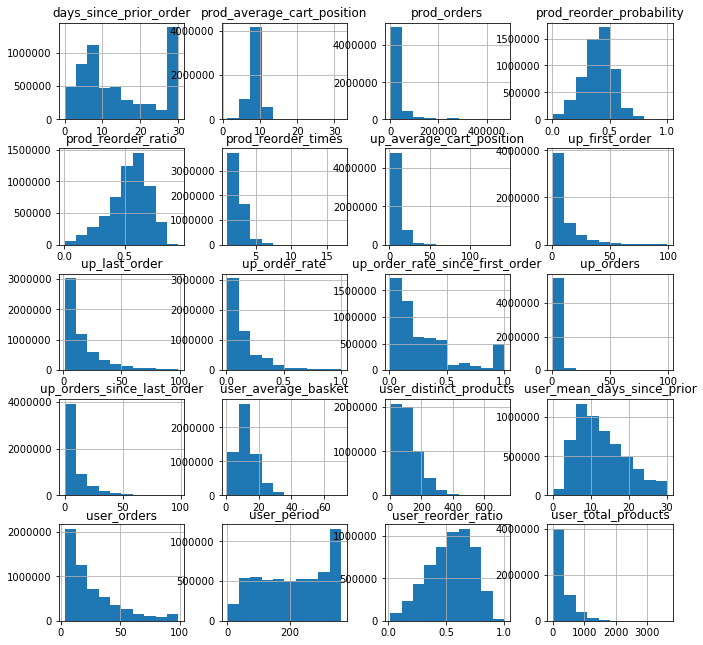

In [13]:
X_train[X_train.dtypes[(X_train.dtypes=="float64")|(X_train.dtypes=="int64")]
                        .index.values].hist(figsize=[11,11])

In [14]:
X_train.isnull().any()

days_since_prior_order             False
prod_average_cart_position         False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_ratio                 False
prod_reorder_times                 False
up_average_cart_position           False
up_first_order                     False
up_last_order                      False
up_order_rate                      False
up_order_rate_since_first_order    False
up_orders                          False
up_orders_since_last_order         False
user_average_basket                False
user_distinct_products             False
user_mean_days_since_prior         False
user_orders                        False
user_period                        False
user_reorder_ratio                  True
user_total_products                False
dtype: bool

In [15]:
len(X_train[lambda x: x.user_reorder_ratio.isnull()])

20565

In [16]:
X_train['user_reorder_ratio'].fillna(0, inplace=True) 

In [17]:
X_eval.isnull().any()

days_since_prior_order             False
prod_average_cart_position         False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_ratio                 False
prod_reorder_times                 False
up_average_cart_position           False
up_first_order                     False
up_last_order                      False
up_order_rate                      False
up_order_rate_since_first_order    False
up_orders                          False
up_orders_since_last_order         False
user_average_basket                False
user_distinct_products             False
user_mean_days_since_prior         False
user_orders                        False
user_period                        False
user_reorder_ratio                  True
user_total_products                False
dtype: bool

In [18]:
X_eval['user_reorder_ratio'].fillna(0, inplace=True) 

In [19]:
test.isnull().any()

product_id                         False
up_orders                          False
up_first_order                     False
up_last_order                      False
up_average_cart_position           False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_times                 False
prod_reorder_ratio                 False
prod_average_cart_position         False
user_orders                        False
user_period                        False
user_mean_days_since_prior         False
user_total_products                False
user_reorder_ratio                  True
user_distinct_products             False
user_average_basket                False
order_id                           False
days_since_prior_order             False
up_order_rate                      False
up_orders_since_last_order         False
up_order_rate_since_first_order    False
reordered                          False
dtype: bool

In [20]:
test['user_reorder_ratio'].fillna(0, inplace=True)

b. Scaling

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()

In [22]:
X_train_scaled = min_max_scaler.fit_transform(X_train)

In [23]:
X_eval_scaled = min_max_scaler.fit_transform(X_eval)

c. Test Dataset format  

In [33]:
X_test = test[test.columns.difference(['order_id', 'product_id'])]

In [34]:
X_test = X_test.drop(['reordered'], axis=1)

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822288 entries, 0 to 4822287
Data columns (total 20 columns):
days_since_prior_order             float64
prod_average_cart_position         float64
prod_orders                        int64
prod_reorder_probability           float64
prod_reorder_ratio                 float64
prod_reorder_times                 float64
up_average_cart_position           float64
up_first_order                     int64
up_last_order                      int64
up_order_rate                      float64
up_order_rate_since_first_order    float64
up_orders                          int64
up_orders_since_last_order         int64
user_average_basket                float64
user_distinct_products             int64
user_mean_days_since_prior         float64
user_orders                        int64
user_period                        float64
user_reorder_ratio                 float64
user_total_products                int64
dtypes: float64(12), int64(8)
memory usage:

#### Sampling
For SVM, KNN

#### (4) SVM

In [24]:
clf = svm.SVC() # hyperparameter C의 default 값1, 조절가능
svm_model = clf.fit(X_train_scaled, y_train)

TypeError: __init__() got an unexpected keyword argument 'n_job'

In [ ]:
y_pred = clf.predict(X_eval)

#### (5) Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
clf = RandomForestClassifier(n_jobs = 4) 

In [28]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
%%time
pred_y_eval = clf.predict(X_eval)

Wall time: 7.19 s


In [30]:
pred_y_eval =pd.DataFrame(pred_y_eval)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_eval, pred_y_eval)

0.90561437044889381

In [36]:
y_pred = clf.predict(X_test)

In [37]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0


In [38]:
test['reordered'] = y_pred
test.tail()

,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,prod_average_cart_position,...,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
4822283,37070,3,1,3,1.0,123,0.520000,2.460000,0.593496,4.195122,...,3,1.0,1,1.0,1973693,30.0,1.0,0,1.0,1.0
4822284,23767,6,1,6,1.0,224,0.277778,2.074074,0.517857,5.040179,...,6,1.0,1,1.0,544191,13.0,1.0,0,1.0,1.0
4822285,13128,3,1,3,1.0,728,0.669421,6.016529,0.833791,4.234890,...,3,1.0,1,1.0,2267535,27.0,1.0,0,1.0,1.0
4822286,19675,26,1,26,1.0,39,0.833333,6.500000,0.846154,4.000000,...,26,1.0,1,1.0,1714200,9.0,1.0,0,1.0,1.0
4822287,47210,4,1,4,1.0,11,0.285714,1.571429,0.363636,6.090909,...,4,1.0,1,1.0,2913671,30.0,1.0,0,1.0,1.0


In [39]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered == 1:   
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('random_forest_submit.csv', index=False)

formatting and writing to submission file ...


#### (6) KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs = 4)

In [43]:
%%time
knn.fit(X_train_scaled, y_train)

Wall time: 2min 8s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
pred_y_eval = knn.predict(X_eval_scaled)

In [ ]:
accuracy_score(y_eval, pred_y_eval)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
test['reordered'] = y_pred
test.tail()

In [ ]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered == 1:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('knn_submit.csv', index=False)